In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE

import seaborn as sns

In [3]:
# Load mnist dataset 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)


In [4]:
train_features = []
train_labels = []
for features, labels in train_loader:
    train_features.append(features.view(-1, 28*28).numpy())
    train_labels.append(labels.numpy())

train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

test_features = []
test_labels = []
for features, labels in test_loader:
    test_features.append(features.view(-1, 28*28).numpy())
    test_labels.append(labels.numpy())

test_features = np.concatenate(test_features, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

In [5]:
print("Length of train features: ", len(train_features))    
print("Length of train labels: ", len(train_labels))
print("Length of test features: ", len(test_features))
print("Length of test labels: ", len(test_labels))

Length of train features:  60000
Length of train labels:  60000
Length of test features:  10000
Length of test labels:  10000


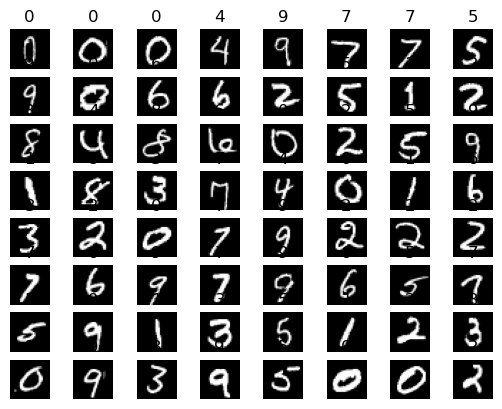

In [6]:
images, labels = next(iter(train_loader))
for i in range (64):
    plt.subplot(8,8,i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(labels[i].item())
    plt.axis('off')
plt.show()

In [7]:
# Define model architecture 
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def activations(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
       
        return torch.relu(self.fc2(x))

In [8]:
model = MLP()
untrained_model = copy.deepcopy(model)
caseh_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
losses = []

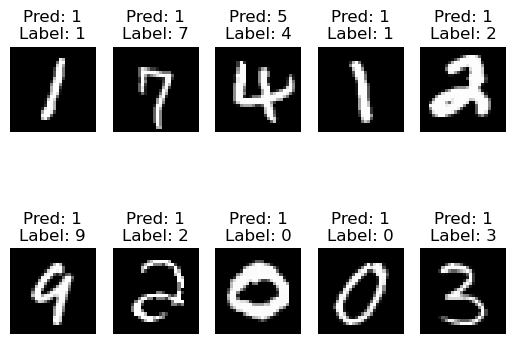

Untrained Model - Accuracy: 0.1192, F1 Score: 0.0584


In [9]:
#Untrained  model output 
untrained_outputs = untrained_model(torch.tensor(test_features, dtype=torch.float32))
# plot the output below image 
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(test_features[i].reshape(28,28), cmap='gray')
    # pred and label on each image
    plt.axis('off')


   
    plt.title(f'Pred: {torch.argmax(untrained_outputs[i]).item()}\nLabel: {test_labels[i]}')
plt.show()
_, untrained_preds = torch.max(untrained_outputs, 1)
untrained_accuracy = accuracy_score(test_labels, untrained_preds.numpy())
untrained_f1 = f1_score(test_labels, untrained_preds.numpy(), average='weighted')
print(f'Untrained Model - Accuracy: {untrained_accuracy:.4f}, F1 Score: {untrained_f1:.4f}')    

In [10]:
# training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for image, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(image)
        loss = caseh_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

Epoch [10/100], Loss: 0.1384
Epoch [20/100], Loss: 0.1013
Epoch [30/100], Loss: 0.0842
Epoch [40/100], Loss: 0.0728
Epoch [50/100], Loss: 0.0645
Epoch [60/100], Loss: 0.0566
Epoch [70/100], Loss: 0.0524
Epoch [80/100], Loss: 0.0478
Epoch [90/100], Loss: 0.0451
Epoch [100/100], Loss: 0.0404


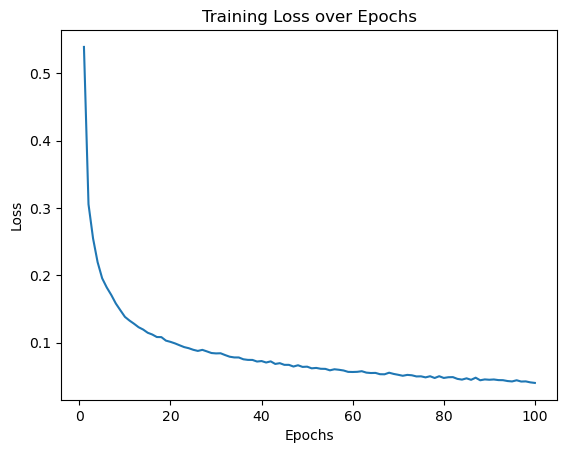

In [11]:
plt.plot(range(1, epochs+1), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

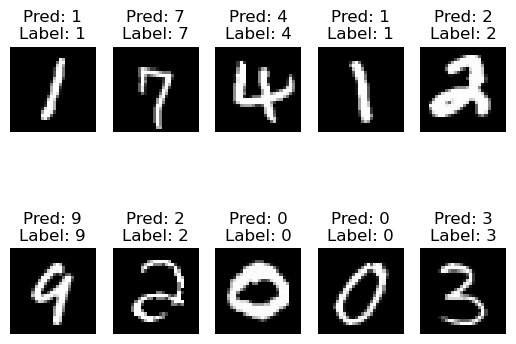

In [12]:
# sample outputs after training
model.eval()
with torch.no_grad():
    trained_outputs = model(torch.tensor(test_features, dtype=torch.float32))
# plot the output below image 
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(test_features[i].reshape(28,28), cmap='gray')
    # pred and label on each image
    plt.axis('off')
    plt.title(f'Pred: {torch.argmax(trained_outputs[i]).item()}\nLabel: {test_labels[i]}')
plt.show()


Trained Model - Accuracy: 0.9565, F1 Score: 0.9565


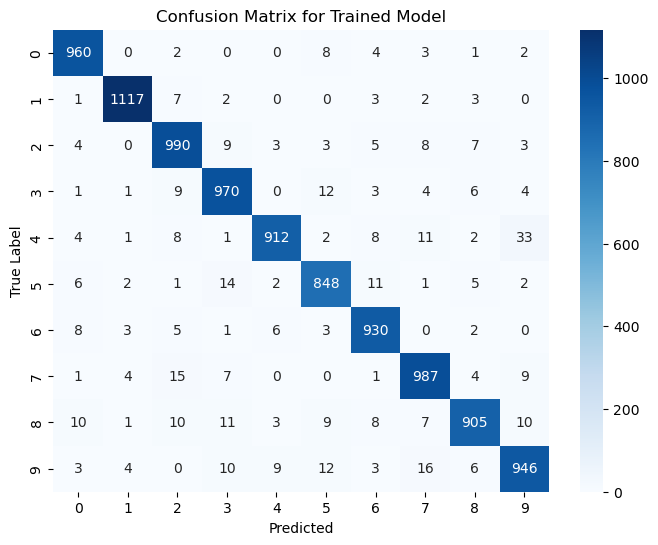

In [13]:
# pred and metrics
_, trained_preds = torch.max(trained_outputs, 1)
trained_accuracy = accuracy_score(test_labels, trained_preds.numpy())
trained_f1 = f1_score(test_labels, trained_preds.numpy(), average='weighted')
print(f'Trained Model - Accuracy: {trained_accuracy:.4f}, F1 Score: {trained_f1:.4f}')
# confunstion matrix
cm = confusion_matrix(test_labels, trained_preds.numpy())
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Trained Model')
plt.show()


Random Forest - Accuracy: 0.9725, F1 Score: 0.9723


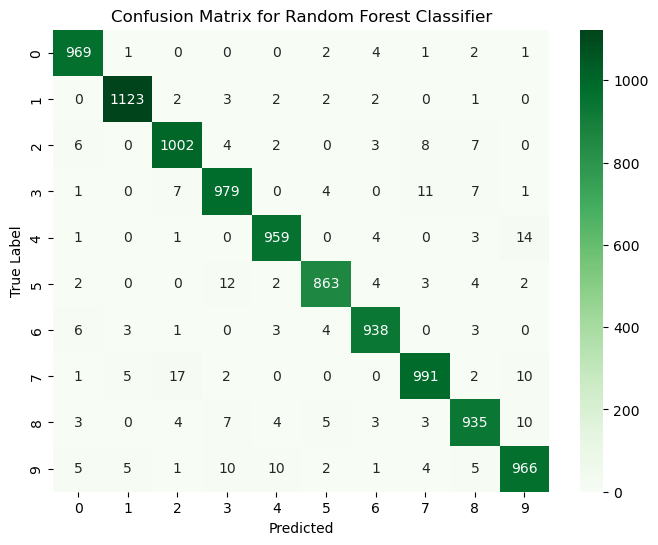

In [14]:
# randomforest classifier
rf=RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_features, train_labels)
rf_preds = rf.predict(test_features)
rf_accuracy = accuracy_score(test_labels, rf_preds)
rf_f1 = f1_score(test_labels, rf_preds, average='macro')
print(f'Random Forest - Accuracy: {rf_accuracy:.4f}, F1 Score: {rf_f1:.4f}')
#condusion matrix
cm_rf = confusion_matrix(test_labels, rf_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()


Logistic Regression - Accuracy: 0.9257, F1 Score: 0.9247


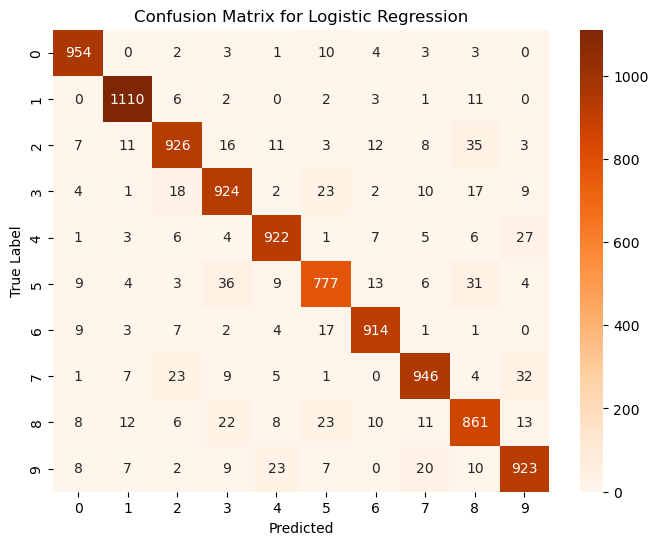

In [15]:
# logistic regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_features, train_labels)
logreg_preds = log_reg.predict(test_features)
logreg_accuracy = accuracy_score(test_labels, logreg_preds)
logreg_f1 = f1_score(test_labels, logreg_preds, average='macro')
print(f'Logistic Regression - Accuracy: {logreg_accuracy:.4f}, F1 Score: {logreg_f1:.4f}')
# confusion matrix
cm_logreg = confusion_matrix(test_labels, logreg_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Oranges', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


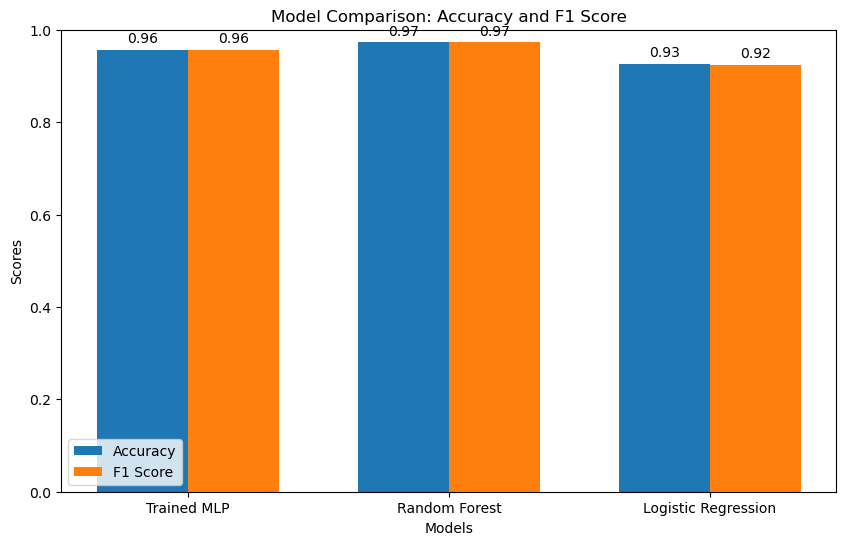

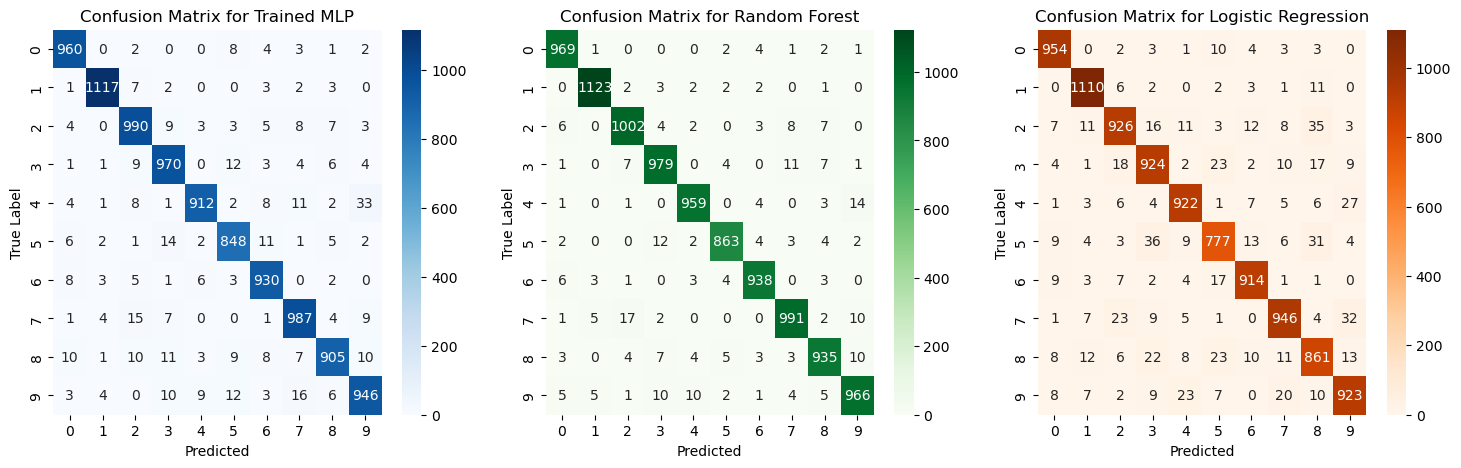

In [16]:
# compatison of all models except untrained model 
models = ['Trained MLP', 'Random Forest', 'Logistic Regression']
accuracies = [trained_accuracy, rf_accuracy, logreg_accuracy]
f1_scores = [trained_f1, rf_f1, logreg_f1]  
x = np.arange(len(models))
width = 0.35
fig, ax = plt.subplots(figsize=(10,6))
bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: Accuracy and F1 Score')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
plt.ylim(0, 1)
plt.show()

# comparison of confusion matrices except untrained model
conf_matrices = [cm, cm_rf, cm_logreg]
titles = ['Trained MLP', 'Random Forest', 'Logistic Regression']
cm_cmaps = ['Blues', 'Greens', 'Oranges']
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 
for ax, cmatrix, title, cmap in zip(axes, conf_matrices, titles, cm_cmaps):
    sns.heatmap(cmatrix, annot=True, fmt='d', cmap=cmap, xticklabels=range(10), yticklabels=range(10), ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix for {title}')
plt.show()


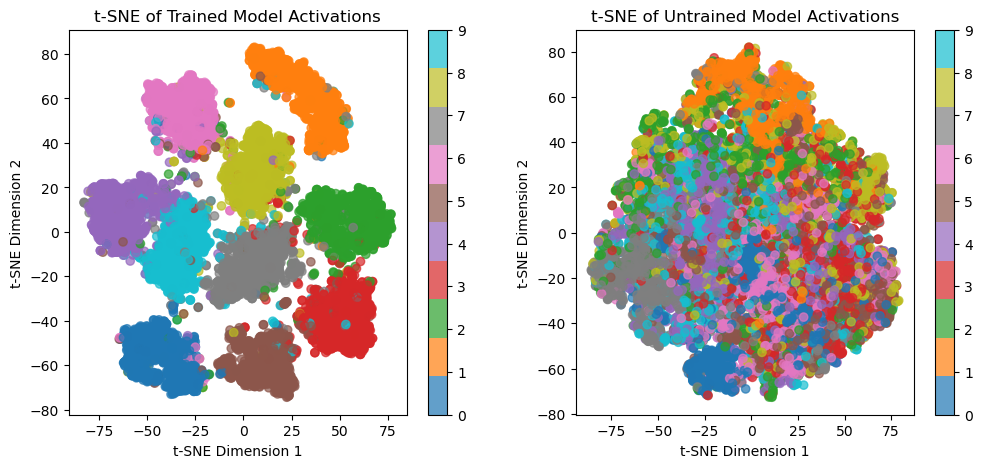

In [17]:
# compatig T-sne of trianend and untrained model 
def get_activations(model, data):
    model.eval()
    with torch.no_grad():
        activations = model.activations(torch.tensor(data, dtype=torch.float32))
    return activations.numpy()
trained_activations = get_activations(model, test_features)
untrained_activations = get_activations(untrained_model, test_features)
tsne = TSNE(n_components=2, random_state=42)
trained_tsne = tsne.fit_transform(trained_activations)
untrained_tsne = tsne.fit_transform(untrained_activations)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
scatter = plt.scatter(trained_tsne[:, 0], trained_tsne[:, 1], c=test_labels, cmap='tab10', alpha=0.7)
plt.title('t-SNE of Trained Model Activations')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, ticks=range(10))
plt.subplot(1, 2, 2)
scatter = plt.scatter(untrained_tsne[:, 0], untrained_tsne[:, 1], c=test_labels, cmap='tab10', alpha=0.7)
plt.title('t-SNE of Untrained Model Activations')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, ticks=range(10))
plt.show()


Trained MLP on Fashion-MNIST - Accuracy: 0.0835, F1 Score: 0.0757


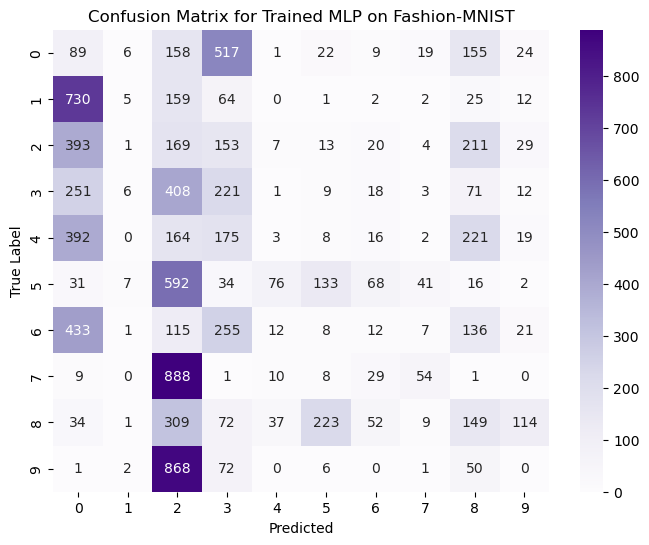

In [18]:
# Testing trained MLP on MNIST -fashion dataset
fashion_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
fashion_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=fashion_transform)
fashion_test_loader = torch.utils.data.DataLoader(dataset=fashion_test_dataset, batch_size=64, shuffle=True)
fashion_test_features = []
fashion_test_labels = []
for features, labels in fashion_test_loader:
    fashion_test_features.append(features.view(-1, 28*28).numpy())
    fashion_test_labels.append(labels.numpy())
fashion_test_features = np.concatenate(fashion_test_features, axis=0)
fashion_test_labels = np.concatenate(fashion_test_labels, axis=0)
fashion_outputs = model(torch.tensor(fashion_test_features, dtype=torch.float32))
_, fashion_preds = torch.max(fashion_outputs, 1)
fashion_accuracy = accuracy_score(fashion_test_labels, fashion_preds.numpy())
fashion_f1 = f1_score(fashion_test_labels, fashion_preds.numpy(), average='weighted')
print(f'Trained MLP on Fashion-MNIST - Accuracy: {fashion_accuracy:.4f}, F1 Score: {fashion_f1:.4f}')
# confusion matrix
cm_fashion = confusion_matrix(fashion_test_labels, fashion_preds.numpy())
plt.figure(figsize=(8,6))
sns.heatmap(cm_fashion, annot=True, fmt='d', cmap='Purples', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Trained MLP on Fashion-MNIST')
plt.show()


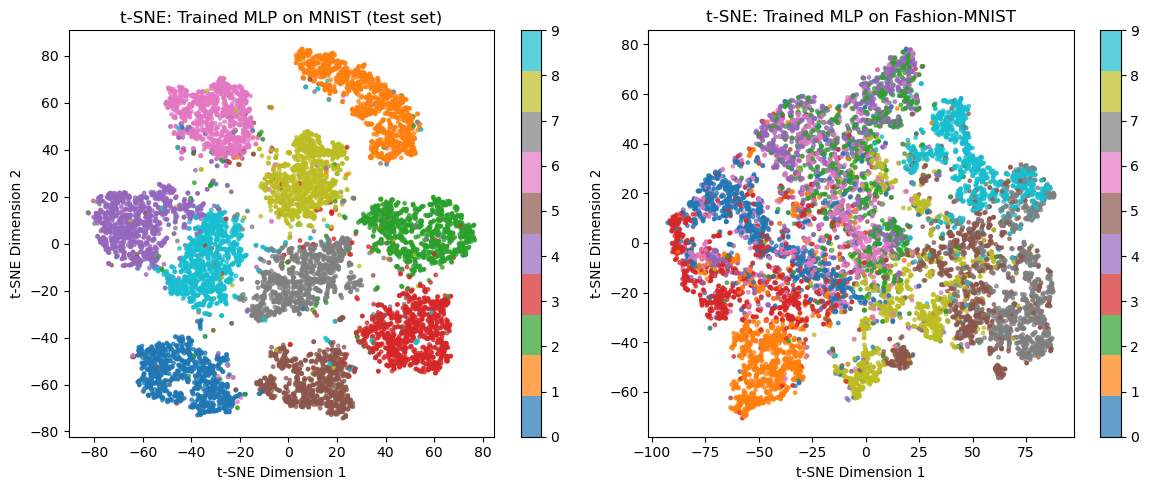

In [19]:
# t-SNE visualization: compare trained MNIST activations (trained_tsne) with Fashion-MNIST activations
# compute fashion activations and t-SNE (trained_tsne already computed for MNIST test set)
fashion_activations = get_activations(model, fashion_test_features)
tsne_fashion = TSNE(n_components=2, random_state=42)
fashion_tsne = tsne_fashion.fit_transform(fashion_activations)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(trained_tsne[:, 0], trained_tsne[:, 1], c=test_labels, cmap='tab10', alpha=0.7, s=6)
plt.title('t-SNE: Trained MLP on MNIST (test set)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(ticks=range(10))

plt.subplot(1,2,2)
plt.scatter(fashion_tsne[:, 0], fashion_tsne[:, 1], c=fashion_test_labels, cmap='tab10', alpha=0.7, s=6)
plt.title('t-SNE: Trained MLP on Fashion-MNIST')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(ticks=range(10))

plt.tight_layout()
plt.show()

In [20]:
#Implement a simple CNN with a convolutional layer having 32 filters of size 3x3, a maxpool layer, a fully connected layer with 128 neurons and an output layer with 10 neurons (for the 10 classes) and ReLU activation. Train on MNIST dataset.
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
cnn_model = SimpleCNN()
cnn_criterion = nn.CrossEntropyLoss()       
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
cnn_epochs = 10
# training loop for CNN
for epoch in range(cnn_epochs):
    cnn_model.train()
    epoch_loss = 0
    for images, labels in train_loader:
        cnn_optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = cnn_criterion(outputs, labels)
        loss.backward()
        cnn_optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    print(f'CNN Epoch [{epoch+1}/{cnn_epochs}], Loss: {avg_loss:.4f}')
times=[]
# evaluate CNN
cnn_model.eval()
with torch.no_grad():
    start = time.time()
    cnn_outputs = cnn_model(torch.tensor(test_features.reshape(-1, 1, 28, 28), dtype=torch.float32))
    end = time.time()
    time_taken = end - start
    times.append(time_taken)
_, cnn_preds = torch.max(cnn_outputs, 1)
cnn_accuracy = accuracy_score(test_labels, cnn_preds.numpy())
cnn_f1 = f1_score(test_labels, cnn_preds.numpy(), average='weighted')
print(f'CNN Model - Accuracy: {cnn_accuracy:.4f}, F1 Score: {cnn_f1:.4f}')      





CNN Epoch [1/10], Loss: 0.2280
CNN Epoch [2/10], Loss: 0.0736
CNN Epoch [3/10], Loss: 0.0498
CNN Epoch [4/10], Loss: 0.0370
CNN Epoch [5/10], Loss: 0.0281
CNN Epoch [6/10], Loss: 0.0222
CNN Epoch [7/10], Loss: 0.0183
CNN Epoch [8/10], Loss: 0.0152
CNN Epoch [9/10], Loss: 0.0123
CNN Epoch [10/10], Loss: 0.0086
CNN Model - Accuracy: 0.9858, F1 Score: 0.9858


In [21]:
#Additionally, use two any pretrained CNNs of your choice (e.g. AlexNet, MobileNet, or EfficientNet) for inference.
import torchvision.models as models

alexnet = models.alexnet(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)

# Modify the final layer for 10 classes
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, 10)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 10)

# Evaluate AlexNet
alexnet.eval()
with torch.no_grad():
    # First create the tensor with the correct shape, then repeat channels
    input_tensor = torch.tensor(test_features.reshape(-1, 1, 28, 28), dtype=torch.float32)
    # print(input_tensor.shape)
    input_tensor = input_tensor.repeat(1, 3, 1, 1)  # Repeat the channel dimension 3 times
    print(input_tensor.shape)
    start_time = time.time()
    alexnet_outputs = alexnet(F.interpolate(input_tensor, size=(224, 224)))
    endtime = time.time()
    time_taken = endtime - start_time
    times.append(time_taken)

_, alexnet_preds = torch.max(alexnet_outputs, 1)
alexnet_accuracy = accuracy_score(test_labels, alexnet_preds.numpy())
alexnet_f1 = f1_score(test_labels, alexnet_preds.numpy(), average='weighted')
print(f'AlexNet Model - Accuracy: {alexnet_accuracy:.4f}, F1 Score: {alexnet_f1:.4f}')       

# Evaluate MobileNet
mobilenet.eval()
with torch.no_grad():
    # Use the same approach for MobileNet
    input_tensor = torch.tensor(test_features.reshape(-1, 1, 28, 28), dtype=torch.float32)
    input_tensor = input_tensor.repeat(1, 3, 1, 1)  # Repeat the channel dimension 3 times
    # time execution
    time_start = time.time()
    mobilenet_outputs = mobilenet(input_tensor)
    time_end = time.time()
    time_taken = time_end - time_start
    times.append(time_taken)
    


_, mobilenet_preds = torch.max(mobilenet_outputs, 1)
mobilenet_accuracy = accuracy_score(test_labels, mobilenet_preds.numpy())
mobilenet_f1 = f1_score(test_labels, mobilenet_preds.numpy(), average='weighted')
print(f'MobileNet Model - Accuracy: {mobilenet_accuracy:.4f}, F1 Score: {mobilenet_f1:.4f}')

#• Compare all three models:Accuracy, F1-score, confusion matrix- Model size (number of parameters)- Inference time on test set


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the mo

torch.Size([10000, 3, 28, 28])
AlexNet Model - Accuracy: 0.0679, F1 Score: 0.0302
MobileNet Model - Accuracy: 0.0952, F1 Score: 0.0429


In [22]:
# make table having time coloumn and number of parameter for each model
model_names = ['Simple CNN', 'AlexNet', 'MobileNet']
accuracies_cnn = [cnn_accuracy, alexnet_accuracy, mobilenet_accuracy]
f1_scores_cnn = [cnn_f1, alexnet_f1, mobilenet_f1]
# making table for number of parameters
num_params = [sum(p.numel() for p in cnn_model.parameters()),
              sum(p.numel() for p in alexnet.parameters()),
              sum(p.numel() for p in mobilenet.parameters())]
x = np.arange(len(model_names))
# making table not bar plot
import pandas as pd
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies_cnn,
    'F1 Score': f1_scores_cnn,
    'Number of Parameters': num_params, 
    'Inference Time (s)': times
})
print(comparison_df)    




        Model  Accuracy  F1 Score  Number of Parameters  Inference Time (s)
0  Simple CNN    0.9858  0.985801                804554            1.141483
1     AlexNet    0.0679  0.030219              57044810          302.062154
2   MobileNet    0.0952  0.042909               2236682           82.556399
